# Project ‐ Where to rent in Singapore?

# Setup

In [1]:
#imports for use
import pandas as pd
import requests
import numpy as np

#import Beautiful Soup for web scrape
from bs4 import BeautifulSoup

#install necessary packages
#get_ipython().system('conda install -c conda-forge geopy --yes')
#get_ipython().system('conda install -c conda-forge folium=0.5.0 --yes')

#converting an address into latitude and longitude values
from geopy.geocoders import Nominatim 

#library to handle requests
import requests 

#matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#map rendering library
import folium

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#additional mapping
from folium import plugins
from folium.plugins import HeatMap

# Scrape Wikipedia Singapore postal code page using Beautiful Soup

In [2]:
url = "https://en.wikipedia.org/wiki/Postal_codes_in_Singapore"
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")
table = soup.find("table", {"class":"wikitable"})
SGpostcode = pd.read_html(str(table))[0]

In [3]:
SGpostcode

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,2,"07, 08","Anson, Tanjong Pagar"
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,4,"09, 10","Telok Blangah, Harbourfront"
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."
5,6,17,"High Street, Beach Road (partial)"
6,7,"18, 19","Middle Road, Golden Mile, Beach Road (partial)"
7,8,"20, 21","Little India, Farrer Park, Jalan Besar, Lavender"
8,9,"22, 23","Orchard, Cairnhill, River Valley"
9,10,"24, 25, 26, 27","Ardmore, Bukit Timah, Holland Road, Tanglin"


# Cleaning

In [4]:
#cleaning SGpostcode

#drop Postal Sector column as this will not be used
SGpostcode = SGpostcode.drop('Postal sector(1st 2 digits of 6-digit postal codes)',1)

#rename columns to capitalise each word for conformity
SGpostcode.columns = ["Postal District", "General Location"]

#remove multiple values in General Location. first location will be used as central point for location
SGpostcode['General Location'] = SGpostcode['General Location'].str.split(',').str[0]

In [5]:
SGpostcode

,Postal District,General Location
0,1,Raffles Place
1,2,Anson
2,3,Bukit Merah
3,4,Telok Blangah
4,5,Pasir Panjang
5,6,High Street
6,7,Middle Road
7,8,Little India
8,9,Orchard
9,10,Ardmore


In [6]:
#use geolocator to assign Postal District with latitude and longitude
#provide geolocator with app name
geolocator = Nominatim(user_agent="SGpostcodeFinder")

#create lists for lattitude and longittude
lat = []
long = []

#loop for each Postal District
for dist in SGpostcode["General Location"]:

    location = geolocator.geocode(dist +", Singapore")
    lat.append(location.latitude)
    long.append(location.longitude)

#insert the lists to main dataset    
SGpostcode["Latitude"] = lat
SGpostcode["Longitude"] = long

In [7]:
SGpostcode

,Postal District,General Location,Latitude,Longitude
0,1,Raffles Place,1.283542,103.851460
1,2,Anson,1.273796,103.843473
2,3,Bukit Merah,1.274864,103.820276
3,4,Telok Blangah,1.271020,103.809695
4,5,Pasir Panjang,1.276201,103.791476
5,6,High Street,1.290383,103.849732
6,7,Middle Road,1.298630,103.853861
7,8,Little India,1.306843,103.849274
8,9,Orchard,1.303116,103.831371
9,10,Ardmore,1.310266,103.828681


In [8]:
# load postal code csv created from KML file
SGpostcode_CSV = pd.read_csv(r'C:\Users\Swill\SAM_Data\SG_PostalDistricts\Singapore_PostalCode.csv')

In [9]:
# sort the file into postl district order and reset index
SGpostcode_CSV = SGpostcode_CSV.sort_values('id').reset_index(drop=True)

In [10]:
# rename columns
SGpostcode_CSV.columns = ["Postal District", "General Location", "Latitude", "Longitude"]

In [11]:
SGpostcode_CSV

,Postal District,General Location,Latitude,Longitude
0,1,Marina Area,1.281632,103.857248
1,2,CBD,1.272167,103.842780
2,3,Central South,1.286189,103.817772
3,4,Keppel,1.271282,103.817022
4,5,South West,1.295909,103.777698
5,6,City Hall,1.292577,103.849194
6,7,Beach Road,1.300595,103.858292
7,8,Little India,1.310853,103.854434
8,9,Orchard,1.302264,103.839234
9,10,Tanglin,1.313139,103.806978


In [12]:
SGpostcode_CSV.dtypes

Postal District       int64
General Location     object
Latitude            float64
Longitude           float64
dtype: object

# A general map of Singapore

In [13]:
#a general map of Singapore CREATED FROM CSV data

#use geopy to find latitude and longitude of Singapore
sgaddress = 'Singapore, Singapore'
#sglocation = geolocator.geocode(sgaddress)

#set latitude and longitude manually for best map position
sglatitude = 1.3521
sglongitude = 103.8198

#zoom 11 selected to show whole island
map_SG = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

#add markers to map
for lat, lng, location in zip(SGpostcode_CSV['Latitude'], SGpostcode_CSV['Longitude'], SGpostcode_CSV['General Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SG)  

In [14]:
map_SG

# Connect to data.gov.sg and retrieve rental data

In [15]:
#Contains information from { Rentals of Non-Landed Residential Buildings, Quarterly } accessed on { 17/11/2019 } from { https://data.gov.sg/) } 
#which is made available under the terms of the Singapore Open Data Licence version 1.0 { https://data.gov.sg/open-data-licence }

#connect url to data.gov.sg API
url = "https://data.gov.sg/api/action/datastore_search?resource_id=4384e22c-234f-4196-9df8-1941cd41c667&limit=1000&fields=project_name%2C%20postal_district%2C%2025th_percentile%2C%20median%2C%2075th_percentile"
data = requests.get(url).json()

SGrental = pd.DataFrame(data['result']['records'])

In [16]:
SGrental

,25th_percentile,postal_district,project_name,median,75th_percentile
0,2.57,14,# 1 LOFT,3.38,3.54
1,4.65,11,10 SHELFORD,4.92,5.06
2,3.55,13,18 WOODSVILLE,3.84,4.19
3,4.53,9,1919,5,5.07
4,4.75,11,26 NEWTON,5.07,5.28
...,...,...,...,...,...
646,2.31,14,WING FONG MANSIONS/WING FONG COURT,2.56,2.88
647,2.76,25,WOODHAVEN,3.01,3.46
648,2.83,9,YONG AN PARK,3.02,3.19
649,3.8,11,ZEDGE,3.9,4.18


In [17]:
#rename columns
SGrental.columns = ["25th Percentile", "Postal District", "Project Name", "Median", "75th Percentile"]

SGrental = SGrental[["Postal District", "Project Name", "25th Percentile", "Median", "75th Percentile"]]

#set types
SGrental["25th Percentile"] = SGrental["25th Percentile"].astype(float)
SGrental["Median"] = SGrental["Median"].astype(float)
SGrental["75th Percentile"] = SGrental["75th Percentile"].astype(float)

In [18]:
SGrental

,Postal District,Project Name,25th Percentile,Median,75th Percentile
0,14,# 1 LOFT,2.57,3.38,3.54
1,11,10 SHELFORD,4.65,4.92,5.06
2,13,18 WOODSVILLE,3.55,3.84,4.19
3,9,1919,4.53,5.00,5.07
4,11,26 NEWTON,4.75,5.07,5.28
...,...,...,...,...,...
646,14,WING FONG MANSIONS/WING FONG COURT,2.31,2.56,2.88
647,25,WOODHAVEN,2.76,3.01,3.46
648,9,YONG AN PARK,2.83,3.02,3.19
649,11,ZEDGE,3.80,3.90,4.18


# Initital exploration 

In [19]:
#intial exploration of data
SGrental.describe()

,25th Percentile,Median,75th Percentile
count,651.000000,651.000000,651.000000
mean,3.444270,3.738771,4.050983
std,0.973716,1.038609,1.100416
min,1.510000,1.620000,1.770000
25%,2.660000,2.925000,3.160000
50%,3.370000,3.670000,4.040000
75%,4.060000,4.410000,4.780000
max,7.600000,8.190000,8.560000


In [20]:
#create SGdata as mean rental rate of median within each postal code
SGdata = SGrental.groupby(["Postal District"], as_index=False).mean()

#cast Postal District to integer for easy sorting
SGdata["Postal District"] = SGdata["Postal District"].astype(int)

#sort
SGdata = SGdata.sort_values(["Postal District"])

#replace index
SGdata.set_index("Postal District", inplace=True)

#inner join SGdata and SGpost to give latitude and longitude for plotting
SGdata = pd.concat([SGdata, SGpostcode_CSV], axis=1, join='inner').reindex(SGdata.index)

#cleanup additional column from join
SGdata = SGdata.drop(columns=["Postal District"])

SGdata = SGdata.drop(28)

In [21]:
SGdata

,25th Percentile,Median,75th Percentile,General Location,Latitude,Longitude
Postal District,,,,,,
1,4.560909,4.878182,5.189091,CBD,1.272167,103.842780
2,4.836000,5.253333,5.626667,Central South,1.286189,103.817772
3,4.141304,4.504783,4.797826,Keppel,1.271282,103.817022
4,3.688889,4.053889,4.411667,South West,1.295909,103.777698
5,3.522000,3.781667,4.075667,City Hall,1.292577,103.849194
6,6.380000,7.350000,7.750000,Beach Road,1.300595,103.858292
7,4.036667,4.420000,4.885556,Little India,1.310853,103.854434
8,3.748333,4.120000,4.394167,Orchard,1.302264,103.839234
9,4.213977,4.537045,4.876250,Tanglin,1.313139,103.806978


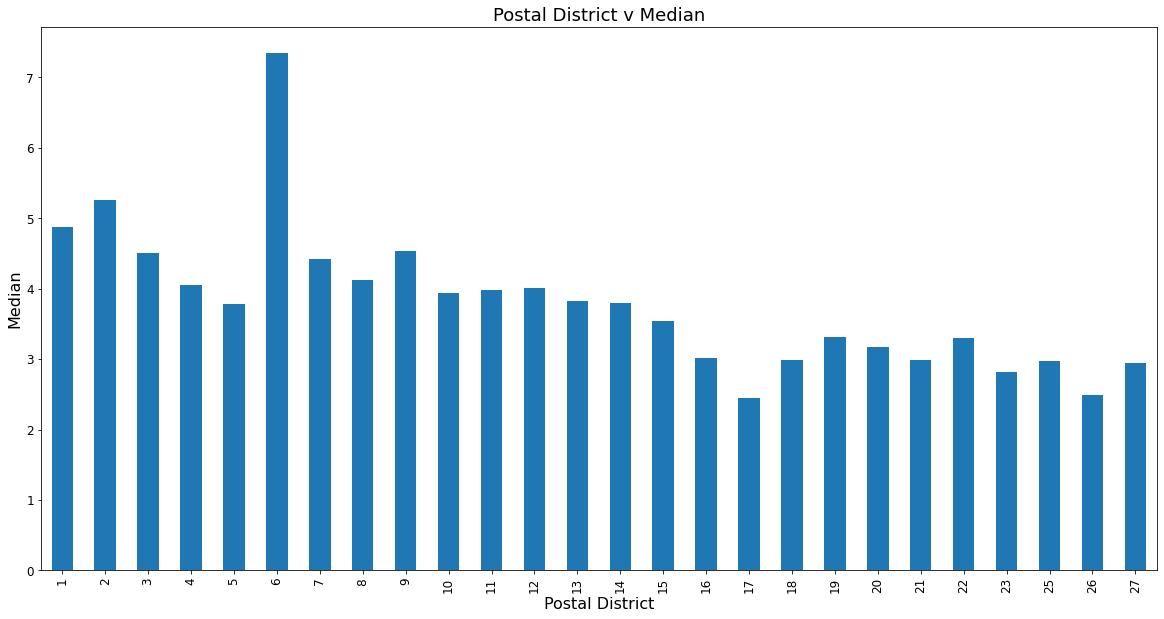

In [22]:
#graph Median rental rates for comparison
SGgraph = SGdata["Median"]

#plot bar
SGgraph.plot(kind="bar", figsize=(20,10), fontsize=12)

#formatting
plt.title('Postal District v Median', fontsize=18)
plt.xlabel('Postal District', fontsize=16)
plt.ylabel('Median', fontsize=16)
plt.show()

# Create bubble map of Singapore rent

In [23]:
#create base map zoom 12 selected 
base_map = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

#add circle marker to map using Median as radius
#multiply all radius for clarity and visual impact
for i in range(0,len(SGdata)):
   folium.Circle(
      location=[SGdata.iloc[i]['Latitude'], SGdata.iloc[i]['Longitude']],
      radius=SGdata.iloc[i]['Median']*400,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(base_map)

#add markers to map set radius of marker to 2 not to ditract from map view informaiton
for lat, lng, location in zip(SGpostcode_CSV['Latitude'], SGpostcode_CSV['Longitude'], SGpostcode_CSV['General Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map)

#show map
base_map

# Foursqaure API use

In [24]:
#Foursquare required details
CLIENT_ID = 'S2YDPIQFORGXOCZHCHFOSBZ3S0ZQZSDWDVASWLKILS5LQ4M0' 
CLIENT_SECRET = 'TUHYBUMFK1BRDAH3PW1IAQVATDSFZB4JLHODA2UYN3VVW55R'
VERSION = '20180605'

In [25]:
#function to select 2000 venues within 2000m
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
#create copy of SGdata for venue work
SGdatav = SGdata.reset_index(drop=False)

In [27]:
SGdatav

,Postal District,25th Percentile,Median,75th Percentile,General Location,Latitude,Longitude
0,1,4.560909,4.878182,5.189091,CBD,1.272167,103.842780
1,2,4.836000,5.253333,5.626667,Central South,1.286189,103.817772
2,3,4.141304,4.504783,4.797826,Keppel,1.271282,103.817022
3,4,3.688889,4.053889,4.411667,South West,1.295909,103.777698
4,5,3.522000,3.781667,4.075667,City Hall,1.292577,103.849194
5,6,6.380000,7.350000,7.750000,Beach Road,1.300595,103.858292
6,7,4.036667,4.420000,4.885556,Little India,1.310853,103.854434
7,8,3.748333,4.120000,4.394167,Orchard,1.302264,103.839234
8,9,4.213977,4.537045,4.876250,Tanglin,1.313139,103.806978
9,10,3.647903,3.932419,4.220000,Newton,1.333708,103.819433


In [28]:
#run function to create Postal District venues
SGvenues = getNearbyVenues(names=SGdatav["Postal District"], latitudes=SGdatav["Latitude"], longitudes=SGdatav["Longitude"])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27


In [29]:
SGvenues

,Postal District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,1.272167,103.842780,Two Men Bagel House,1.274465,103.844421,Bagel Shop
1,1,1.272167,103.842780,Oasia Downtown Hotel,1.276070,103.844334,Hotel
2,1,1.272167,103.842780,DON DON DONKI,1.274742,103.843383,Discount Store
3,1,1.272167,103.842780,Nylon Coffee Roasters,1.276657,103.840073,Coffee Shop
4,1,1.272167,103.842780,Binomio Spanish Restaurante,1.277713,103.842248,Spanish Restaurant
...,...,...,...,...,...,...,...
2356,27,1.407048,103.868455,Three by Table Concepts,1.391379,103.876066,Asian Restaurant
2357,27,1.407048,103.868455,Rower’s Bay,1.420974,103.862343,Waterfront
2358,27,1.407048,103.868455,Fernvale LRT Station (SW5),1.392344,103.876267,Light Rail Station
2359,27,1.407048,103.868455,Din Tai Fung 鼎泰豐 (Din Tai Fung),1.391252,103.876110,Asian Restaurant


In [30]:
#show how many venues in each Postal District
SGvenues.groupby("Postal District").count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal District,,,,,,
1,100,100,100,100,100,100
2,100,100,100,100,100,100
3,100,100,100,100,100,100
4,100,100,100,100,100,100
5,100,100,100,100,100,100
6,100,100,100,100,100,100
7,100,100,100,100,100,100
8,100,100,100,100,100,100
9,100,100,100,100,100,100


# Heatmap of Singapore venues

In [31]:
#create base map zoom 12 selected 
base_map2 = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

HeatMap(data=SGvenues[['Venue Latitude', 'Venue Longitude']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist(), radius=9, max_zoom=13).add_to(base_map2)

#add markers to map set radius of marker to 2 not to ditract from map view informaiton 
for lat, lng, location in zip(SGpostcode_CSV['Latitude'], SGpostcode_CSV['Longitude'], SGpostcode_CSV['General Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map2)

base_map2

# Prepare for clustering

In [32]:
#one hot encoding
SGonehot = pd.get_dummies(SGvenues[['Venue Category']], prefix="", prefix_sep="")

#add district column back to dataframe
SGonehot['Postal District'] = SGvenues['Postal District'] 

#move Postal District column to the first column
fixed_columns = [SGonehot.columns[-1]] + list(SGonehot.columns[:-1])
SGonehot = SGonehot[fixed_columns]

#group by Postal District
SGonehot = SGonehot.groupby('Postal District').mean().reset_index()

SGonehot

,Postal District,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.010000,0.00,0.020000,0.00,0.01,0.00,0.00,0.00
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.01,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.01,0.00,0.00,0.00
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.01,0.01,...,0.01,0.000000,0.010000,0.00,0.010000,0.00,0.01,0.00,0.00,0.00
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.00,0.010000,0.00,0.00,0.00,0.00,0.00
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,...,0.00,0.000000,0.010000,0.01,0.020000,0.00,0.02,0.00,0.00,0.00
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,...,0.00,0.000000,0.040000,0.01,0.000000,0.00,0.01,0.00,0.00,0.00
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.02,0.010000,0.00,0.01,0.00,0.00,0.00
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,...,0.00,0.000000,0.010000,0.02,0.010000,0.00,0.00,0.00,0.00,0.00
8,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
9,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00


In [33]:
#create dataframe
SGonehotT = SGonehot
SGonehotT["Postal District"] = SGonehotT["Postal District"].astype(str)

#print each Postal District top 10 venues
num_top_venues = 10

for postd in SGonehotT['Postal District']:
    print("----"+postd+"----")
    temp = SGonehotT[SGonehotT['Postal District'] == postd].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1----
                  venue  freq
0   Japanese Restaurant  0.08
1                 Hotel  0.08
2                  Café  0.07
3           Coffee Shop  0.05
4            Food Court  0.04
5  Gym / Fitness Center  0.04
6    Spanish Restaurant  0.03
7     Korean Restaurant  0.03
8    Seafood Restaurant  0.03
9             BBQ Joint  0.02


----2----
                    venue  freq
0      Chinese Restaurant  0.08
1                    Café  0.07
2                    Park  0.06
3                  Bakery  0.06
4     Japanese Restaurant  0.05
5               Bookstore  0.03
6              Food Court  0.03
7  Furniture / Home Store  0.03
8             Coffee Shop  0.03
9      Seafood Restaurant  0.03


----3----
                          venue  freq
0  Theme Park Ride / Attraction  0.05
1                Scenic Lookout  0.04
2                         Beach  0.03
3                    Theme Park  0.03
4                          Park  0.03
5                         Trail  0.03
6            Chine

In [34]:
#function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
#new dataframe displaying the top 10 venues in Postal District
num_top_venues = 10

#ordinal indicator
indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Postal District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe
SGpostDvenues = pd.DataFrame(columns=columns)
SGpostDvenues['Postal District'] = SGonehotT['Postal District']

for ind in np.arange(SGonehotT.shape[0]):
    SGpostDvenues.iloc[ind, 1:] = return_most_common_venues(SGonehotT.iloc[ind, :], num_top_venues)

SGpostDvenues

,Postal District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Japanese Restaurant,Hotel,Café,Coffee Shop,Food Court,Gym / Fitness Center,Spanish Restaurant,Korean Restaurant,Seafood Restaurant,BBQ Joint
1,2,Chinese Restaurant,Café,Park,Bakery,Japanese Restaurant,Bookstore,Food Court,Furniture / Home Store,Coffee Shop,Seafood Restaurant
2,3,Theme Park Ride / Attraction,Scenic Lookout,Beach,Theme Park,Park,Trail,Chinese Restaurant,Japanese Restaurant,Café,Multiplex
3,4,Coffee Shop,Sandwich Place,Convenience Store,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Gym / Fitness Center,Park,Shopping Mall
4,5,Hotel,Japanese Restaurant,Coffee Shop,Bar,Steakhouse,Gym,Shopping Mall,Harbor / Marina,Cocktail Bar,Café
5,6,Indian Restaurant,Hotel,Japanese Restaurant,Chinese Restaurant,Waterfront,Cocktail Bar,Park,Stadium,Art Gallery,Dim Sum Restaurant
6,7,Indian Restaurant,Chinese Restaurant,Hotel,Supermarket,Café,Japanese Restaurant,Soup Place,Ice Cream Shop,Noodle House,Bakery
7,8,Hotel,Japanese Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Dumpling Restaurant
8,9,Bakery,Garden,Chinese Restaurant,Ice Cream Shop,Café,Italian Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Seafood Restaurant
9,10,Café,Japanese Restaurant,Asian Restaurant,Italian Restaurant,Flower Shop,Bakery,Garden,Shopping Mall,Restaurant,Coffee Shop


# Calculate optimal k

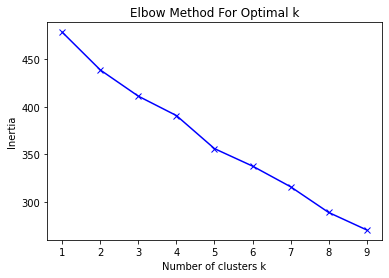

In [36]:
#create temporary data for k 
SGonehotTE = SGonehotT

#use Min Max as scaler option
mms = MinMaxScaler()
mms.fit(SGonehotTE)
data_transformed = mms.transform(SGonehotTE)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

#plot chart for optimal k    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()    

In [37]:
SGonehotTE

,Postal District,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.010000,0.00,0.020000,0.00,0.01,0.00,0.00,0.00
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.01,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.01,0.00,0.00,0.00
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.01,0.01,...,0.01,0.000000,0.010000,0.00,0.010000,0.00,0.01,0.00,0.00,0.00
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.00,0.010000,0.00,0.00,0.00,0.00,0.00
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,...,0.00,0.000000,0.010000,0.01,0.020000,0.00,0.02,0.00,0.00,0.00
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,...,0.00,0.000000,0.040000,0.01,0.000000,0.00,0.01,0.00,0.00,0.00
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.02,0.010000,0.00,0.01,0.00,0.00,0.00
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,...,0.00,0.000000,0.010000,0.02,0.010000,0.00,0.00,0.00,0.00,0.00
8,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
9,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00


# Cluster data

In [38]:
#set number of clusters
kclusters = 6

SGonehotT_clustering = SGonehotT.drop('Postal District', 1)

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SGonehotT_clustering)

#add clustering labels
SGpostDvenues.insert(0, 'Cluster Labels', kmeans.labels_)

#cast postal district to int64 for join
SGpostDvenues["Postal District"] = SGpostDvenues["Postal District"].astype(int)

In [39]:
SGpostDvenues

,Cluster Labels,Postal District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,1,Japanese Restaurant,Hotel,Café,Coffee Shop,Food Court,Gym / Fitness Center,Spanish Restaurant,Korean Restaurant,Seafood Restaurant,BBQ Joint
1,3,2,Chinese Restaurant,Café,Park,Bakery,Japanese Restaurant,Bookstore,Food Court,Furniture / Home Store,Coffee Shop,Seafood Restaurant
2,3,3,Theme Park Ride / Attraction,Scenic Lookout,Beach,Theme Park,Park,Trail,Chinese Restaurant,Japanese Restaurant,Café,Multiplex
3,3,4,Coffee Shop,Sandwich Place,Convenience Store,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Gym / Fitness Center,Park,Shopping Mall
4,1,5,Hotel,Japanese Restaurant,Coffee Shop,Bar,Steakhouse,Gym,Shopping Mall,Harbor / Marina,Cocktail Bar,Café
5,5,6,Indian Restaurant,Hotel,Japanese Restaurant,Chinese Restaurant,Waterfront,Cocktail Bar,Park,Stadium,Art Gallery,Dim Sum Restaurant
6,5,7,Indian Restaurant,Chinese Restaurant,Hotel,Supermarket,Café,Japanese Restaurant,Soup Place,Ice Cream Shop,Noodle House,Bakery
7,1,8,Hotel,Japanese Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Dumpling Restaurant
8,3,9,Bakery,Garden,Chinese Restaurant,Ice Cream Shop,Café,Italian Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Seafood Restaurant
9,3,10,Café,Japanese Restaurant,Asian Restaurant,Italian Restaurant,Flower Shop,Bakery,Garden,Shopping Mall,Restaurant,Coffee Shop


In [40]:
#create dataset for comparison merging
SG_merged = SGpostcode_CSV

#merge data to add latitude/longitude for each neighborhood
SG_merged = SG_merged.join(SGpostDvenues.set_index('Postal District'), on='Postal District')

#cast Cluster labels to integers
SG_merged['Cluster Labels'] = SG_merged['Cluster Labels'].fillna(0).astype(np.int64)

#drop Postal District 24 from dataset
SG_merged = SG_merged.drop([24])

In [41]:
SG_merged

,Postal District,General Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Marina Area,1.281632,103.857248,1,Japanese Restaurant,Hotel,Café,Coffee Shop,Food Court,Gym / Fitness Center,Spanish Restaurant,Korean Restaurant,Seafood Restaurant,BBQ Joint
1,2,CBD,1.272167,103.842780,3,Chinese Restaurant,Café,Park,Bakery,Japanese Restaurant,Bookstore,Food Court,Furniture / Home Store,Coffee Shop,Seafood Restaurant
2,3,Central South,1.286189,103.817772,3,Theme Park Ride / Attraction,Scenic Lookout,Beach,Theme Park,Park,Trail,Chinese Restaurant,Japanese Restaurant,Café,Multiplex
3,4,Keppel,1.271282,103.817022,3,Coffee Shop,Sandwich Place,Convenience Store,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Gym / Fitness Center,Park,Shopping Mall
4,5,South West,1.295909,103.777698,1,Hotel,Japanese Restaurant,Coffee Shop,Bar,Steakhouse,Gym,Shopping Mall,Harbor / Marina,Cocktail Bar,Café
5,6,City Hall,1.292577,103.849194,5,Indian Restaurant,Hotel,Japanese Restaurant,Chinese Restaurant,Waterfront,Cocktail Bar,Park,Stadium,Art Gallery,Dim Sum Restaurant
6,7,Beach Road,1.300595,103.858292,5,Indian Restaurant,Chinese Restaurant,Hotel,Supermarket,Café,Japanese Restaurant,Soup Place,Ice Cream Shop,Noodle House,Bakery
7,8,Little India,1.310853,103.854434,1,Hotel,Japanese Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Dumpling Restaurant
8,9,Orchard,1.302264,103.839234,3,Bakery,Garden,Chinese Restaurant,Ice Cream Shop,Café,Italian Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Seafood Restaurant
9,10,Tanglin,1.313139,103.806978,3,Café,Japanese Restaurant,Asian Restaurant,Italian Restaurant,Flower Shop,Bakery,Garden,Shopping Mall,Restaurant,Coffee Shop


# Map of clusters

In [42]:
#create map of clusters
map_clusters = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SG_merged['Latitude'], SG_merged['Longitude'], SG_merged['Postal District'], SG_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster Labels ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# Analysis

In [43]:
#Cluster 0
SG_merged.loc[SG_merged['Cluster Labels'] == 0, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Newton,Chinese Restaurant,Supermarket,Hotel,Bakery,Café,Coffee Shop,Indian Restaurant,Ice Cream Shop,Noodle House,Food Court
11,Toa Payoh,Chinese Restaurant,Food Court,Café,Noodle House,Coffee Shop,Convenience Store,Seafood Restaurant,Indian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant
12,Central East,Food Court,Chinese Restaurant,Asian Restaurant,Café,Vegetarian / Vegan Restaurant,Seafood Restaurant,Noodle House,Indian Restaurant,Vietnamese Restaurant,BBQ Joint
14,Katong,Coffee Shop,Chinese Restaurant,Food Court,Asian Restaurant,Noodle House,Café,Convenience Store,Supermarket,Ice Cream Shop,Japanese Restaurant
18,Hougang,Chinese Restaurant,Food Court,Café,Coffee Shop,Bakery,Park,Thai Restaurant,Ice Cream Shop,Spa,Supermarket
23,Far North West,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,North,Coffee Shop,Chinese Restaurant,Asian Restaurant,Fried Chicken Joint,Food Court,Indian Restaurant,Thai Restaurant,Seafood Restaurant,Convenience Store,Café
26,Yishun,Food Court,Coffee Shop,Asian Restaurant,Bus Station,Fast Food Restaurant,Airport Terminal,Restaurant,Thai Restaurant,Café,Soup Place
27,Seletar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#Cluster 1
SG_merged.loc[SG_merged['Cluster Labels'] == 1, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marina Area,Japanese Restaurant,Hotel,Café,Coffee Shop,Food Court,Gym / Fitness Center,Spanish Restaurant,Korean Restaurant,Seafood Restaurant,BBQ Joint
4,South West,Hotel,Japanese Restaurant,Coffee Shop,Bar,Steakhouse,Gym,Shopping Mall,Harbor / Marina,Cocktail Bar,Café
7,Little India,Hotel,Japanese Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Dumpling Restaurant


In [45]:
#Cluster 2
SG_merged.loc[SG_merged['Cluster Labels'] == 2, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Changi,Coffee Shop,Convenience Store,Fast Food Restaurant,Park,Bakery,Café,Supermarket,Fried Chicken Joint,Food Court,Sandwich Place
17,Tampines,Convenience Store,Food Court,Chinese Restaurant,Coffee Shop,Café,Fast Food Restaurant,Noodle House,Sandwich Place,Asian Restaurant,Supermarket
20,Central West,Convenience Store,Fast Food Restaurant,Asian Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Food Court,Supermarket,Shopping Mall,Dessert Shop
21,Jurong,Convenience Store,Coffee Shop,Supermarket,Fast Food Restaurant,Italian Restaurant,Café,Shopping Mall,Sandwich Place,Asian Restaurant,Food Court


In [46]:
#Cluster 3
SG_merged.loc[SG_merged['Cluster Labels'] == 3, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,CBD,Chinese Restaurant,Café,Park,Bakery,Japanese Restaurant,Bookstore,Food Court,Furniture / Home Store,Coffee Shop,Seafood Restaurant
2,Central South,Theme Park Ride / Attraction,Scenic Lookout,Beach,Theme Park,Park,Trail,Chinese Restaurant,Japanese Restaurant,Café,Multiplex
3,Keppel,Coffee Shop,Sandwich Place,Convenience Store,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Gym / Fitness Center,Park,Shopping Mall
8,Orchard,Bakery,Garden,Chinese Restaurant,Ice Cream Shop,Café,Italian Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Seafood Restaurant
9,Tanglin,Café,Japanese Restaurant,Asian Restaurant,Italian Restaurant,Flower Shop,Bakery,Garden,Shopping Mall,Restaurant,Coffee Shop
13,Eunos,Chinese Restaurant,Café,Bar,Coffee Shop,Hotel,Noodle House,Ice Cream Shop,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Dim Sum Restaurant
15,Upper East Coast,Airport Lounge,Sandwich Place,Café,Chinese Restaurant,Candy Store,Coffee Shop,Airport,Public Art,Border Crossing,Fried Chicken Joint
19,Ang Mo Kio,Café,Trail,Korean Restaurant,Food Court,Historic Site,Soccer Field,Bakery,Japanese Restaurant,Nature Preserve,Hill


In [47]:
#Cluster 4
SG_merged.loc[SG_merged['Cluster Labels'] == 4, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,North West,Farm,Chinese Restaurant,Campground,Peking Duck Restaurant,Park,Paper / Office Supplies Store,Paintball Field,Paella Restaurant,Outdoor Sculpture,Other Repair Shop


In [48]:
#Cluster 5
SG_merged.loc[SG_merged['Cluster Labels'] == 5, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,City Hall,Indian Restaurant,Hotel,Japanese Restaurant,Chinese Restaurant,Waterfront,Cocktail Bar,Park,Stadium,Art Gallery,Dim Sum Restaurant
6,Beach Road,Indian Restaurant,Chinese Restaurant,Hotel,Supermarket,Café,Japanese Restaurant,Soup Place,Ice Cream Shop,Noodle House,Bakery
